In [ ]:
! pip install transformers datasets
! pip install rouge-score nltk evaluate
! pip install -U datasets huggingface_hub fsspec

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0b163b960e7ed0ccb94abe01fd78aacefa4e8cbd2b8d15cf5b80e2429b5c17a2
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 31.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.34.1
    Uninstalling huggingface-hub-0.34.1:
      Successfully uninstalled huggingface-hub-0.34.1


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
import os
os.chdir('/content/drive/MyDrive/EricZ2')

print("Current directory:", os.getcwd())
print("\nFiles in current directory:")
for file in os.listdir():
    print(f"  {file}")

Current directory: /content/drive/MyDrive/EricZ2

Files in current directory:
  test.json
  train.json
  val.json
  4thRL_SFT.ipynb
  train_processed_4thFIXED_tokenizer
  val_processed_4thFIXED_tokenizer
  runs
  therapy_checkpoints_4thFIXED
  val_processed_4thFIXED.pkl
  train_processed_4thFIXED.pkl
  Retrain4thSFT_therapist_token_ (1).ipynb


In [ ]:
import os, sys
import argparse
import math
import time
import datetime
from google.colab import drive
import pickle
import json
import evaluate
import re
import pandas as pd
import seaborn as sns
import numpy as np
import random
from torch.nn import functional as F
from itertools import chain
import matplotlib.pyplot as plt

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler, TensorDataset
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import get_linear_schedule_with_warmup

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import glob

import nltk
nltk.download('punkt')

import torch.nn as nn

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    print("TensorBoard not available, training will continue without logging")
    class SummaryWriter:
        def __init__(self, *args, **kwargs): pass
        def add_scalar(self, *args, **kwargs): pass
        def add_scalars(self, *args, **kwargs): pass
        def close(self): pass

"""
Automatic Therapy Model Evaluation
Compare generated responses against test dataset ground truth
"""

try:
    import evaluate
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    from sklearn.metrics import accuracy_score, f1_score, classification_report
    import nltk
    # Download required NLTK data
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
except ImportError:
    print("Warning: Some evaluation libraries not found. Install with:")
    print("pip install evaluate nltk scikit-learn")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def fix_seed(seed=42):
    """Fix random seeds for reproducibility"""
    import random
    import numpy as np
    import torch

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Random seed set to {seed}")

SEED = 42
fix_seed(SEED)


Random seed set to 42


In [ ]:
class FixedTrainerV2():
    """
    Fixed trainer - uses corrected data preprocessing
    """
    def __init__(self, args, train_data_path='', val_data_path=''):
        self.args = args

        # Set seed at the very beginning of initialization
        self.fix_seed(self.args.seed)

        if torch.cuda.is_available():
            self.args.device = torch.device(f"cuda:{self.args.gpu}")
        else:
            self.args.device = torch.device("cpu")

        print(f"Using device: {self.args.device}")
        print(f"Random seed: {self.args.seed}")


        # Use corrected data preprocessing
        print("Using corrected data preprocessing...")
        train_tokenizer = dataset_loader_fixed_v2(
            data_path=train_data_path,
            save_path='train_processed_4thFIXED.pkl',
            max_length=self.args.max_len
        )

        print("Processing validation data...")
        val_tokenizer = dataset_loader_fixed_v2(
            data_path=val_data_path,
            save_path='val_processed_4thFIXED.pkl',
            max_length=self.args.max_len
        )

        if train_tokenizer is None or val_tokenizer is None:
            raise ValueError("Data preprocessing failed!")

        print("Loading corrected tokenizer...")
        self.tokenizer = GPT2Tokenizer.from_pretrained('train_processed_4thFIXED_tokenizer')

        vocab = self.tokenizer.get_vocab()
        self.args.vocab_size = len(vocab)

        # Special token IDs
        self.args.bos_id = self.tokenizer.bos_token_id
        self.args.eos_id = self.tokenizer.eos_token_id
        self.args.pad_id = self.tokenizer.pad_token_id
        self.args.problem_id = self.tokenizer.convert_tokens_to_ids("<problem>")
        self.args.user_id = self.tokenizer.convert_tokens_to_ids("<user>")
        self.args.user_emotion_id = self.tokenizer.convert_tokens_to_ids("<user_emotion>")
        self.args.therapist_id = self.tokenizer.convert_tokens_to_ids("<therapist>")
        self.args.therapist_emotion_id = self.tokenizer.convert_tokens_to_ids("<therapist_emotion>")

        print(f"Vocabulary size: {self.args.vocab_size}")
        print(f"Special tokens: <bos>={self.args.bos_id}, <eos>={self.args.eos_id}")
        print(f"Key tokens: <therapist>={self.args.therapist_id}, <therapist_emotion>={self.args.therapist_emotion_id}")

        # Verify emotion word tokenization
        emotion_tokens = ["anger", "sadness", "depression", "disgust", "fear", "joy", "neutral"]
        print(f"Verifying emotion word tokenization:")
        for emotion in emotion_tokens:
            tokens = self.tokenizer.encode(emotion, add_special_tokens=False)
            decoded = self.tokenizer.decode(tokens[0]) if tokens else "ERROR"
            print(f"   {emotion}: Token ID {tokens[0] if tokens else 'N/A'} -> '{decoded}'")

        # Load model
        print("Loading model...")
        self.fix_seed(self.args.seed)
        self.model = GPT2LMHeadModel.from_pretrained(self.args.model_type).to(self.args.device)
        self.model.resize_token_embeddings(self.args.vocab_size)

        self.args.max_len = min(self.args.max_len, self.model.config.n_ctx)
        print(f"Maximum sequence length: {self.args.max_len}")

        # Load optimizer
        print("Loading optimizer...")
        self.optim = torch.optim.AdamW(self.model.parameters(), lr=self.args.lr)
        self.best_loss = sys.float_info.max
        self.last_epoch = 0

        # Use corrected datasets
        print("Creating corrected data loaders...")
        train_dataset = TherapyDataset('train_processed_4thFIXED.pkl')
        val_dataset = TherapyDataset('val_processed_4thFIXED.pkl')

        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.args.batch_size,
            shuffle=True,
            num_workers=self.args.num_workers,
            pin_memory=True
        )

        self.valid_loader = DataLoader(
            val_dataset,
            batch_size=self.args.batch_size,
            shuffle=False,
            num_workers=self.args.num_workers,
            pin_memory=True
        )

        # Calculate training steps
        num_batches = len(self.train_loader)
        self.args.total_train_steps = self.args.num_epochs * num_batches
        self.args.warmup_steps = int(self.args.warmup_ratio * self.args.total_train_steps)

        print(f"Training steps: {self.args.total_train_steps}, Warmup: {self.args.warmup_steps}")

        self.sched = get_linear_schedule_with_warmup(
            self.optim,
            num_warmup_steps=self.args.warmup_steps,
            num_training_steps=self.args.total_train_steps,
        )

        # TensorBoard
        try:
            self.writer = SummaryWriter(log_dir="runs/therapy_training_4thFIXED")
            print("TensorBoard logging enabled")
        except Exception as e:
            print(f"TensorBoard not available: {e}")
            self.writer = type('DummyWriter', (), {
                'add_scalar': lambda *args, **kwargs: None,
                'add_scalars': lambda *args, **kwargs: None,
                'close': lambda: None
            })()

        # Create checkpoint directory
        if not os.path.exists(self.args.ckpt_dir):
            os.makedirs(self.args.ckpt_dir)

        # Checkpoint loading
        if self.args.ckpt_name is not None:
            ckpt_path = f"{self.args.ckpt_dir}/{self.args.ckpt_name}.ckpt"
            if os.path.exists(ckpt_path):
                print("Loading trained checkpoint...")
                ckpt = torch.load(ckpt_path, map_location=self.args.device)
                self.model.load_state_dict(ckpt['model_state_dict'])
                self.optim.load_state_dict(ckpt['optim_state_dict'])
                self.sched.load_state_dict(ckpt['sched_state_dict'])
                self.best_loss = ckpt['loss']
                self.last_epoch = ckpt['epoch']
                print(f"Resuming training from {self.args.ckpt_name}.ckpt")
            else:
                print(f"Cannot find checkpoint {ckpt_path}")
                print("Training will start with initialized model")

        print("Fixed version setup complete!")

    def train_with_validation(self):
        """
        Enhanced training function with better validation and debugging
        """
        self.fix_seed(self.args.seed)
        print("Starting fixed version training!")

        # Pre-training validation: test if model can correctly predict <therapist_emotion>
        print("\nPre-training validation...")
        self.validate_emotion_prediction()

        start_epoch = self.last_epoch + 1
        for epoch in range(start_epoch, start_epoch + self.args.num_epochs):
            self.model.train()

            print(f"\n{'='*20} Epoch: {epoch}/{start_epoch + self.args.num_epochs - 1} {'='*20}")
            train_losses = []
            train_ppls = []

            # Training loop
            for i, batch in enumerate(tqdm(self.train_loader, desc=f"Training Epoch {epoch}")):
                try:
                    input_ids = batch['input_ids'].to(self.args.device)
                    attention_mask = batch['attention_mask'].to(self.args.device)
                    labels = batch['labels'].to(self.args.device)

                    # Forward pass
                    outputs = self.model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )

                    loss = outputs.loss

                    # Backward pass
                    self.optim.zero_grad()
                    loss.backward()

                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                    self.optim.step()
                    self.sched.step()

                    # Record metrics
                    train_losses.append(loss.detach())
                    ppl = torch.exp(loss.detach())
                    train_ppls.append(ppl)

                    if (i + 1) % 50 == 0:
                        current_lr = self.sched.get_last_lr()[0]
                        print(f"  Step {i+1}/{len(self.train_loader)}: Loss={loss.item():.4f}, PPL={ppl.item():.2f}, LR={current_lr:.2e}")

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print("CUDA out of memory! Clearing cache...")
                        if hasattr(torch.cuda, 'empty_cache'):
                            torch.cuda.empty_cache()
                        continue
                    else:
                        raise e

            # Calculate epoch metrics
            train_losses = [loss.item() for loss in train_losses]
            train_ppls = [ppl.item() if not math.isinf(ppl.item()) else 1e+8 for ppl in train_ppls]
            train_loss = np.mean(train_losses)
            train_ppl = np.mean(train_ppls)

            print(f"Training Loss: {train_loss:.4f} | Training Perplexity: {train_ppl:.2f}")

            # Log to TensorBoard
            self.writer.add_scalar("Loss/train", train_loss, epoch)
            self.writer.add_scalar("PPL/train", train_ppl, epoch)

            self.last_epoch += 1

            # Validation
            valid_loss, valid_ppl = self.validation()

            # Test emotion generation every 2 epochs
            if epoch % 2 == 0:
                print("\nTesting emotion generation capability...")
                self.test_emotion_generation()

            # Save model
            state_dict = {
                'model_state_dict': self.model.state_dict(),
                'optim_state_dict': self.optim.state_dict(),
                'sched_state_dict': self.sched.state_dict(),
                'loss': valid_loss,
                'epoch': self.last_epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'train_ppl': train_ppl,
                'valid_ppl': valid_ppl
            }

            # Save epoch checkpoint
            regular_ckpt_name = f"therapy_model_4thFIXED_epoch_{epoch}_loss_{round(valid_loss, 4)}.ckpt"
            torch.save(state_dict, f"{self.args.ckpt_dir}/{regular_ckpt_name}")
            print(f"Saved epoch checkpoint: {regular_ckpt_name}")

            # Save best model
            if valid_loss < self.best_loss:
                self.best_loss = valid_loss
                state_dict['loss'] = self.best_loss

                best_ckpt_name = f"BEST_therapy_model_4thFIXED_epoch_{epoch}_loss_{round(self.best_loss, 4)}.ckpt"
                torch.save(state_dict, f"{self.args.ckpt_dir}/{best_ckpt_name}")
                print("*" * 10 + " NEW BEST MODEL SAVED " + "*" * 10)
                print(f"Saved best checkpoint: {best_ckpt_name}")

            print(f"Best Validation Loss: {self.best_loss:.4f}")
            print(f"Validation Loss: {valid_loss:.4f} | Validation Perplexity: {valid_ppl:.2f}")

            # Log validation metrics
            self.writer.add_scalar("Loss/valid", valid_loss, epoch)
            self.writer.add_scalar("PPL/valid", valid_ppl, epoch)

            self.writer.add_scalars("Losses", {
                'train': train_loss,
                'valid': valid_loss,
            }, epoch)

        print("Training completed!")

        # Final test
        print("\nFinal test...")
        self.test_emotion_generation()

        self.writer.close()

    def validate_emotion_prediction(self):
        """
        Validate if model can correctly predict <therapist_emotion> tags
        """
        print("Validating if data preprocessing is correct...")

        # Load a training sample
        with open('train_processed_4thFIXED.pkl', 'rb') as f:
            data = pickle.load(f)

        sample = data['input_ids'][0]
        labels = data['labels'][0]

        print(f"Sample sequence: {self.tokenizer.decode(sample, skip_special_tokens=False)}")

        # Find <therapist_emotion> positions
        therapist_emotion_positions = []
        for i, token_id in enumerate(sample):
            if token_id == self.args.therapist_emotion_id:
                therapist_emotion_positions.append(i)

        print(f"<therapist_emotion> positions: {therapist_emotion_positions}")

        # Check labels at these positions
        for pos in therapist_emotion_positions:
            if pos < len(labels):
                label_value = labels[pos]
                if label_value == self.args.therapist_emotion_id:
                    print(f"SUCCESS: Position {pos}: <therapist_emotion> tag will be predicted")
                elif label_value == -100:
                    print(f"ERROR: Position {pos}: <therapist_emotion> tag will NOT be predicted!")
                else:
                    print(f"WARNING: Position {pos}: Abnormal label value: {label_value}")

    def test_emotion_generation(self):
        """
        Test model's emotion generation capability
        """
        self.model.eval()

        test_cases = [
            "<problem>anxiety <user>I'm worried about work <user_emotion>anxiety <therapist>",
            "<problem>depression <user>I feel very sad <user_emotion>sadness <therapist>",
        ]

        print("Testing emotion generation:")

        for i, test_input in enumerate(test_cases, 1):
            input_ids = self.tokenizer.encode(test_input, return_tensors='pt').to(self.args.device)

            with torch.no_grad():
                outputs = self.model.generate(
                    input_ids,
                    do_sample=False,
                    max_new_tokens=30,
                    pad_token_id=self.tokenizer.pad_token_id,
                    eos_token_id=self.tokenizer.eos_token_id,
                )

            generated_ids = outputs[0][len(input_ids[0]):]
            generated_text = self.tokenizer.decode(generated_ids, skip_special_tokens=False)

            # Check if contains <therapist_emotion>
            has_emotion_tag = self.args.therapist_emotion_id in generated_ids.tolist()
            has_eos = self.args.eos_id in generated_ids.tolist()

            print(f"  Test {i}: {test_input[:50]}...")
            print(f"  Generated: '{generated_text}'")
            print(f"  Contains <therapist_emotion>: {has_emotion_tag} {'SUCCESS' if has_emotion_tag else 'ERROR'}")
            print(f"  Contains <eos>: {has_eos} {'SUCCESS' if has_eos else 'ERROR'}")
            print()

    def validation(self):
        """Validation function - same as original version"""
        print("Running validation...")
        self.model.eval()

        valid_losses = []
        valid_ppls = []

        with torch.no_grad():
            for i, batch in enumerate(tqdm(self.valid_loader, desc="Validation")):
                try:
                    input_ids = batch['input_ids'].to(self.args.device)
                    attention_mask = batch['attention_mask'].to(self.args.device)
                    labels = batch['labels'].to(self.args.device)

                    outputs = self.model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )

                    loss = outputs.loss
                    valid_losses.append(loss.detach())
                    ppl = torch.exp(loss.detach())
                    valid_ppls.append(ppl)

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print("CUDA out of memory during validation!")
                        if hasattr(torch.cuda, 'empty_cache'):
                            torch.cuda.empty_cache()
                        continue
                    else:
                        raise e

        valid_losses = [loss.item() for loss in valid_losses]
        valid_ppls = [ppl.item() if not math.isinf(ppl.item()) else 1e+8 for ppl in valid_ppls]
        valid_loss = np.mean(valid_losses)
        valid_ppl = np.mean(valid_ppls)

        if math.isnan(valid_ppl):
            valid_ppl = 1e+8

        return valid_loss, valid_ppl

    def fix_seed(self, seed):
        """Enhanced seed fixing for maximum reproducibility"""
        import random
        import numpy as np
        import torch

        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

        print(f"Fixed random seed to {seed}")



In [ ]:

class Args:
    """Simple args class for Colab"""
    def __init__(self):
        self.seed = 42
        self.gpu = "0"
        self.warmup_ratio = 0.1
        self.num_workers = 0

        self.model_type = None
        self.lr = None
        self.batch_size = None
        self.num_epochs = None
        self.max_len = None
        self.ckpt_dir = None
        self.ckpt_name = None
        self.train_data = None
        self.val_data = None

def dataset_loader_fixed_v2(data_path='', save_path='therapy_processed_4thFIXED.pkl', max_length=128):
    """
    CORRECTED data preprocessing: ensures <therapist_emotion> tags are properly trained

    Key fix: <therapist_emotion> tags are now set to be predicted (not -100)
    """

    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Emotion words as special tokens
    emotion_tokens = [
        "anger", "sadness", "depression", "disgust", "fear", "joy", "neutral"
    ]

    special_tokens = {
        'bos_token': "<bos>",
        'eos_token': "<eos>",
        'pad_token': "<pad>",
        'additional_special_tokens': [
            "<problem>",
            "<user>",
            "<user_emotion>",
            "<therapist>",
            "<therapist_emotion>"
        ] + emotion_tokens
    }

    num_new_tokens = tokenizer.add_special_tokens(special_tokens)
    print(f"Added {num_new_tokens} special tokens")
    print(f"Emotion tokens added: {emotion_tokens}")

    # Verify emotion tokenization
    print(f"Verifying emotion tokenization:")
    for emotion in emotion_tokens:
        tokens = tokenizer.encode(emotion, add_special_tokens=False)
        decoded = tokenizer.decode(tokens[0]) if tokens else "ERROR"
        print(f"   '{emotion}' -> Token ID: {tokens[0] if tokens else 'N/A'} -> '{decoded}'")

    # Get special token IDs
    bos_id = tokenizer.bos_token_id
    eos_id = tokenizer.eos_token_id
    pad_id = tokenizer.pad_token_id
    problem_id = tokenizer.convert_tokens_to_ids("<problem>")
    user_id = tokenizer.convert_tokens_to_ids("<user>")
    user_emotion_id = tokenizer.convert_tokens_to_ids("<user_emotion>")
    therapist_id = tokenizer.convert_tokens_to_ids("<therapist>")
    therapist_emotion_id = tokenizer.convert_tokens_to_ids("<therapist_emotion>")

    print(f"Key token IDs:")
    print(f"   <therapist>: {therapist_id}")
    print(f"   <therapist_emotion>: {therapist_emotion_id}")
    print(f"   <eos>: {eos_id}")

    input_ids_list = []
    attention_mask_list = []
    labels_list = []
    dialogue_lengths = []

    total_sequences = 0
    filtered_sequences = 0

    try:
        with open(data_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded JSON file with {len(data)} conversations")
    except Exception as e:
        print(f"Error loading JSON file: {e}")
        return None

    print(f"Processing {len(data)} therapy conversations...")
    total_examples = 0

    for conversation_idx, conversation in enumerate(tqdm(data, desc="Processing conversations")):
        try:
            problem_type = conversation.get("problem_type", "").strip()
            dialog = conversation.get("dialog", [])

            if not dialog:
                continue

            i = 0
            while i < len(dialog):
                conversation_turns = []

                # Collect user turns
                while i < len(dialog) and dialog[i].get("speaker") != "sys":
                    conversation_turns.append(dialog[i])
                    i += 1

                # Process therapist response
                if i < len(dialog) and dialog[i].get("speaker") == "sys":
                    therapist_turn = dialog[i]

                    if conversation_turns:
                        try:
                            combined_text_parts = []
                            user_emotions = []

                            for turn in conversation_turns:
                                turn_text = turn.get("text", "").strip()
                                turn_emotion = turn.get("emotion", "").strip()

                                if turn_text:
                                    # Clean descriptive text
                                    expression_pattern = r'\s*(The (?:speaker|emotion state)[^.]*\.(?:[^.]*\.)*)'
                                    match = re.search(expression_pattern, turn_text, re.IGNORECASE | re.DOTALL)

                                    if match:
                                        clean_text = turn_text[:match.start()].strip()
                                    else:
                                        clean_text = turn_text

                                    if clean_text:
                                        combined_text_parts.append(clean_text)

                                if turn_emotion:
                                    user_emotions.append(turn_emotion)

                            # Combine user data
                            user_text = " ".join(combined_text_parts)
                            user_emotion = user_emotions[0] if user_emotions else ""

                            # Process therapist data
                            therapist_full_text = therapist_turn.get("text", "").strip()
                            therapist_emotion = therapist_turn.get("emotion", "").strip()

                            # Clean therapist text
                            expression_pattern = r'\s*(The (?:speaker|emotion state)[^.]*\.(?:[^.]*\.)*)'
                            therapist_match = re.search(expression_pattern, therapist_full_text, re.IGNORECASE | re.DOTALL)

                            if therapist_match:
                                therapist_text = therapist_full_text[:therapist_match.start()].strip()
                            else:
                                therapist_text = therapist_full_text

                            if not user_text or not therapist_text:
                                i += 1
                                continue

                            # Show first few samples for debugging
                            if total_examples < 3:
                                print(f"\nSample {total_examples + 1}:")
                                print(f"   User: {user_text[:50]}{'...' if len(user_text) > 50 else ''}")
                                print(f"   User Emotion: {user_emotion}")
                                print(f"   Therapist: {therapist_text}")
                                print(f"   Therapist Emotion: {therapist_emotion}")
                                print("-" * 60)

                            # Tokenize components
                            problem_tokens = tokenizer.encode(problem_type, add_special_tokens=False) if problem_type else []
                            user_tokens = tokenizer.encode(user_text, add_special_tokens=False)
                            user_emotion_tokens = tokenizer.encode(user_emotion, add_special_tokens=False) if user_emotion else []
                            therapist_tokens = tokenizer.encode(therapist_text, add_special_tokens=False)
                            therapist_emotion_tokens = tokenizer.encode(therapist_emotion, add_special_tokens=False) if therapist_emotion else []

                            input_ids = [bos_id]

                            if problem_tokens:
                                input_ids.extend([problem_id] + problem_tokens)

                            input_ids.extend([user_id] + user_tokens)

                            if user_emotion_tokens:
                                input_ids.extend([user_emotion_id] + user_emotion_tokens)

                            input_ids.extend([therapist_id] + therapist_tokens)

                            if therapist_emotion_tokens:
                                input_ids.extend([therapist_emotion_id] + therapist_emotion_tokens)

                            input_ids.append(eos_id)

                            total_sequences += 1

                            # Filter overly long sequences
                            if len(input_ids) > max_length:
                                filtered_sequences += 1
                                if total_sequences <= 5:
                                    print(f"Filtering sequence {total_sequences}: length {len(input_ids)} >= {max_length}")
                                i += 1
                                continue

                            labels = []

                            # BOS - don't predict
                            labels.append(-100)

                            # Problem section - don't predict
                            if problem_tokens:
                                labels.extend([-100] * (len([problem_id] + problem_tokens)))

                            # User section - don't predict
                            labels.extend([-100] * (len([user_id] + user_tokens)))

                            # User emotion section - don't predict
                            if user_emotion_tokens:
                                labels.extend([-100] * (len([user_emotion_id] + user_emotion_tokens)))

                            # Therapist section: don't predict <therapist>, predict text content
                            labels.append(-100)  # <therapist> tag - don't predict
                            labels.extend(therapist_tokens)  # therapist text content - predict

                            # CRITICAL FIX: Therapist emotion section - predict EVERYTHING
                            if therapist_emotion_tokens:
                                labels.append(therapist_emotion_id)  # PREDICT <therapist_emotion> tag
                                labels.extend(therapist_emotion_tokens)  # predict emotion word

                            # EOS - predict
                            labels.append(eos_id)

                            if len(input_ids) != len(labels):
                                print(f"Length mismatch: {len(input_ids)} vs {len(labels)}")
                                print(f"   Input sequence: {tokenizer.decode(input_ids, skip_special_tokens=False)}")
                                i += 1
                                continue

                            if total_examples < 2:
                                print(f"\nSample {total_examples + 1} Labels Debug:")
                                therapist_start = None
                                therapist_emotion_pos = None

                                for idx, (token_id, label) in enumerate(zip(input_ids, labels)):
                                    token_str = tokenizer.decode([token_id])
                                    if token_id == therapist_id:
                                        therapist_start = idx
                                        print(f"   {idx}: {token_str} -> Label: {label} (don't predict)")
                                    elif token_id == therapist_emotion_id:
                                        therapist_emotion_pos = idx
                                        print(f"   {idx}: {token_str} -> Label: {label} (PREDICT!)")
                                    elif therapist_start is not None and therapist_emotion_pos is None and label != -100:
                                        print(f"   {idx}: {token_str} -> Label: {label} (predict text)")
                                    elif therapist_emotion_pos is not None and label != -100:
                                        print(f"   {idx}: {token_str} -> Label: {label} (predict emotion)")

                                print(f"   Prediction target: {tokenizer.decode([l for l in labels if l != -100], skip_special_tokens=False)}")

                            # Create attention mask
                            attention_mask = [1] * len(input_ids)

                            # Padding
                            if len(input_ids) < max_length:
                                pad_length = max_length - len(input_ids)
                                input_ids.extend([pad_id] * pad_length)
                                attention_mask.extend([0] * pad_length)
                                labels.extend([-100] * pad_length)

                            input_ids_list.append(input_ids)
                            attention_mask_list.append(attention_mask)
                            labels_list.append(labels)
                            dialogue_lengths.append(len(therapist_tokens) + len(therapist_emotion_tokens) + 1)  # +1 for emotion tag
                            total_examples += 1

                        except Exception as e:
                            print(f"Error processing conversation {conversation_idx}, sample {total_examples}: {e}")
                            i += 1
                            continue

                i += 1

        except Exception as e:
            print(f"Error processing conversation {conversation_idx}: {e}")
            continue

        if (conversation_idx + 1) % 10 == 0:
            retention_rate = ((total_sequences - filtered_sequences) / total_sequences * 100) if total_sequences > 0 else 0
            print(f"Created {total_examples} samples, filtered {filtered_sequences}/{total_sequences}({retention_rate:.1f}% retention)")

    processed_count = len(input_ids_list)
    retention_rate = ((total_sequences - filtered_sequences) / total_sequences * 100) if total_sequences > 0 else 0

    if dialogue_lengths:
        mean_response_len = np.mean(dialogue_lengths)
        median_response_len = np.median(dialogue_lengths)
        max_response_len = np.max(dialogue_lengths)
        min_response_len = np.min(dialogue_lengths)
    else:
        mean_response_len = median_response_len = max_response_len = min_response_len = 0

    print(f"\nPREPROCESSING COMPLETE")
    print(f"Total sequences processed: {total_sequences}")
    print(f"Sequences filtered out (>= {max_length} tokens): {filtered_sequences}")
    print(f"Successfully created {processed_count} training samples")
    print(f"Retention rate: {retention_rate:.1f}%")
    print(f"Therapist response lengths (text + emotion tag):")
    print(f"    Mean: {mean_response_len:.2f} tokens")
    print(f"    Median: {median_response_len:.2f} tokens")
    print(f"    Min: {min_response_len} tokens")
    print(f"    Max: {max_response_len} tokens")

    if processed_count == 0:
        print("No valid training samples created!")
        return None

    # Save processed data
    processed_data = {
        'input_ids': input_ids_list,
        'attention_mask': attention_mask_list,
        'labels': labels_list,
        'tokenizer_vocab_size': len(tokenizer),
        'special_tokens': special_tokens,
        'stats': {
            'total_conversations': len(data),
            'total_sequences_processed': total_sequences,
            'sequences_filtered': filtered_sequences,
            'total_examples': processed_count,
            'retention_rate': retention_rate,
            'max_length_used': max_length,
            'mean_response_length': mean_response_len,
            'preprocessing_version': 'v2_corrected'
        }
    }

    with open(save_path, 'wb') as f:
        pickle.dump(processed_data, f)

    print(f"Saved processed data to {save_path}")

    # Save tokenizer
    tokenizer_save_path = save_path.replace('.pkl', '_tokenizer')
    tokenizer.save_pretrained(tokenizer_save_path)
    print(f"Saved tokenizer to {tokenizer_save_path}")
    print(f"NEW FILES CREATED - Old files preserved!")

    return tokenizer

class TherapyDataset(Dataset):
    def __init__(self, data_path):
        print(f"Loading processed data from {data_path}...")
        with open(data_path, 'rb') as f:
            self.data = pickle.load(f)

        self.input_ids = self.data['input_ids']
        self.attention_mask = self.data['attention_mask']
        self.labels = self.data['labels']

        print(f"Loaded {len(self.input_ids)} training examples")

        if 'stats' in self.data:
            stats = self.data['stats']
            if 'total_sequences_processed' in stats and 'sequences_filtered' in stats:
                total = stats['total_sequences_processed']
                filtered = stats['sequences_filtered']
                retention = stats.get('retention_rate', 0)
                print(f"Filtering stats: {filtered}/{total} sequences filtered out ({retention:.1f}% retention)")

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

def run_therapy_training_corrected(
    train_data_file="train.json",
    val_data_file="val.json",
    model_type="gpt2",
    batch_size=32,
    num_epochs=20,
    learning_rate=2e-5,
    max_length=128,
    checkpoint_dir="therapy_checkpoints_4thFIXED",
    resume_from=None
):
    """Run training with CORRECTED tokenization and preprocessing"""
    args = Args()
    args.train_data = train_data_file
    args.val_data = val_data_file
    args.model_type = model_type
    args.batch_size = batch_size
    args.num_epochs = num_epochs
    args.lr = learning_rate
    args.max_len = max_length
    args.ckpt_dir = checkpoint_dir
    args.ckpt_name = resume_from

    valid_models = [
        "gpt2"
    ]
    assert args.model_type in valid_models, f"Invalid model. Choose from: {valid_models}"

    print(f"Starting therapy AI training with CORRECTED preprocessing")
    print(f"Model: {args.model_type}")
    print(f"Batch size: {args.batch_size}, Epochs: {args.num_epochs}")
    print(f"Learning rate: {args.lr}, Max length: {args.max_len}")
    print(f"Train data: {args.train_data}, Val data: {args.val_data}")
    print(f"Checkpoint dir: {args.ckpt_dir}")

    trainer = FixedTrainerV2(args, train_data_path=args.train_data, val_data_path=args.val_data)
    trainer.train_with_validation()

    return trainer

def debug_setup_corrected():
    """Debug your current setup for corrected version"""
    print("DEBUGGING CORRECTED SETUP")
    print("="*50)

    # Check data files
    print("Data files:")
    for file in ['train.json', 'val.json']:
        if os.path.exists(file):
            size = os.path.getsize(file) / 1024
            print(f"   {file} ({size:.1f} KB)")
        else:
            print(f"   {file} - MISSING")

    # Check OLD processed files (3rdFIXED)
    print("\nOLD processed files (3rdFIXED):")
    for file in ['train_processed_3rdFIXED.pkl', 'val_processed_3rdFIXED.pkl']:
        if os.path.exists(file):
            size = os.path.getsize(file) / (1024*1024)
            print(f"   {file} ({size:.1f} MB) - OLD VERSION")
        else:
            print(f"   {file} - Not found")

    # Check NEW processed files (4thFIXED)
    print("\nNEW processed files (4thFIXED):")
    for file in ['train_processed_4thFIXED.pkl', 'val_processed_4thFIXED.pkl']:
        if os.path.exists(file):
            size = os.path.getsize(file) / (1024*1024)
            print(f"   {file} ({size:.1f} MB) - CORRECTED VERSION")
        else:
            print(f"   {file} - Will be created")

    # Check tokenizer directories
    print("\nTokenizer directories:")
    for dir_name in ['train_processed_3rdFIXED_tokenizer', 'train_processed_4thFIXED_tokenizer']:
        if os.path.exists(dir_name):
            files = os.listdir(dir_name)
            version = "OLD" if "3rd" in dir_name else "CORRECTED"
            print(f"   {dir_name} ({len(files)} files) - {version}")
        else:
            status = "Will be created" if "4th" in dir_name else "Not found"
            print(f"   {dir_name} - {status}")

    # Check checkpoint directories
    print("\nCheckpoint directories:")
    for dir_name in ['therapy_checkpoints_3rdFIXED', 'therapy_checkpoints_4thFIXED']:
        if os.path.exists(dir_name):
            files = [f for f in os.listdir(dir_name) if f.endswith('.ckpt')]
            version = "OLD" if "3rd" in dir_name else "CORRECTED"
            print(f"   {dir_name} ({len(files)} checkpoints) - {version}")
        else:
            status = "Will be created" if "4th" in dir_name else "Not found"
            print(f"   {dir_name} - {status}")

    print("\nRECOMMENDATION:")
    print("1. Run the corrected preprocessing first")
    print("2. Verify the preprocessing fix worked")
    print("3. Start training with corrected data")
    print("4. Old files (3rdFIXED) will be preserved")

    return True


if __name__ == "__main__":
    debug_setup_corrected()

    trainer = run_therapy_training_corrected(
         train_data_file="train.json",
         val_data_file="val.json",
         num_epochs=20,
         batch_size=32,
         checkpoint_dir="therapy_checkpoints_4thFIXED"
     )

DEBUGGING CORRECTED SETUP
Data files:
   train.json (10811.3 KB)
   val.json (1258.4 KB)

OLD processed files (3rdFIXED):
   train_processed_3rdFIXED.pkl - Not found
   val_processed_3rdFIXED.pkl - Not found

NEW processed files (4thFIXED):
   train_processed_4thFIXED.pkl (4.3 MB) - CORRECTED VERSION
   val_processed_4thFIXED.pkl (0.5 MB) - CORRECTED VERSION

Tokenizer directories:
   train_processed_3rdFIXED_tokenizer - Not found
   train_processed_4thFIXED_tokenizer (5 files) - CORRECTED

Checkpoint directories:
   therapy_checkpoints_3rdFIXED - Not found
   therapy_checkpoints_4thFIXED - Will be created

RECOMMENDATION:
1. Run the corrected preprocessing first
2. Verify the preprocessing fix worked
3. Start training with corrected data
4. Old files (3rdFIXED) will be preserved
Starting therapy AI training with CORRECTED preprocessing
Model: gpt2
Batch size: 32, Epochs: 20
Learning rate: 2e-05, Max length: 128
Train data: train.json, Val data: val.json
Checkpoint dir: therapy_checkpo

Processing conversations:   0%|          | 0/815 [00:00<?, ?it/s]


Sample 1:
   User: I told you.
   User Emotion: sadness
   Therapist: Told me what?
   Therapist Emotion: neutral
------------------------------------------------------------

Sample 1 Labels Debug:
   14: <therapist> -> Label: -100 (don't predict)
   15: T -> Label: 51 (predict text)
   16: old -> Label: 727 (predict text)
   17:  me -> Label: 502 (predict text)
   18:  what -> Label: 644 (predict text)
   19: ? -> Label: 30 (predict text)
   20: <therapist_emotion> -> Label: 50264 (PREDICT!)
   21: neutral -> Label: 29797 (predict emotion)
   22: <eos> -> Label: 50258 (predict emotion)
   Prediction target: Told me what? <therapist_emotion> neutral<eos>

Sample 2:
   User: That you'd be sorry you ever encouraged me to cry ...
   User Emotion: sadness
   Therapist: I'm not sorry at all.
   Therapist Emotion: neutral
------------------------------------------------------------

Sample 2 Labels Debug:
   23: <therapist> -> Label: -100 (don't predict)
   24: I -> Label: 40 (predict text

Processing conversations:   4%|▍         | 31/815 [00:00<00:02, 305.24it/s]

Created 98 samples, filtered 9/107(91.6% retention)
Created 144 samples, filtered 10/154(93.5% retention)
Created 194 samples, filtered 12/206(94.2% retention)
Created 241 samples, filtered 16/257(93.8% retention)


Processing conversations:   8%|▊         | 65/815 [00:00<00:02, 322.15it/s]

Created 273 samples, filtered 19/292(93.5% retention)
Created 315 samples, filtered 22/337(93.5% retention)
Created 347 samples, filtered 24/371(93.5% retention)


Processing conversations:  16%|█▋        | 134/815 [00:00<00:02, 333.98it/s]

Created 402 samples, filtered 25/427(94.1% retention)
Created 444 samples, filtered 28/472(94.1% retention)
Created 481 samples, filtered 30/511(94.1% retention)
Created 498 samples, filtered 36/534(93.3% retention)
Created 531 samples, filtered 37/568(93.5% retention)


Processing conversations:  21%|██        | 169/815 [00:00<00:01, 338.05it/s]

Created 577 samples, filtered 39/616(93.7% retention)
Created 621 samples, filtered 42/663(93.7% retention)
Created 655 samples, filtered 48/703(93.2% retention)


Processing conversations:  25%|██▍       | 203/815 [00:00<00:01, 334.09it/s]

Created 684 samples, filtered 52/736(92.9% retention)
Created 715 samples, filtered 56/771(92.7% retention)
Created 747 samples, filtered 62/809(92.3% retention)
Created 782 samples, filtered 67/849(92.1% retention)


Processing conversations:  30%|██▉       | 242/815 [00:00<00:01, 349.06it/s]

Created 826 samples, filtered 68/894(92.4% retention)
Created 862 samples, filtered 70/932(92.5% retention)
Created 910 samples, filtered 72/982(92.7% retention)
Created 949 samples, filtered 75/1024(92.7% retention)


Processing conversations:  34%|███▍      | 281/815 [00:00<00:01, 359.94it/s]

Created 975 samples, filtered 78/1053(92.6% retention)
Created 1022 samples, filtered 79/1101(92.8% retention)
Created 1064 samples, filtered 79/1143(93.1% retention)
Created 1088 samples, filtered 80/1168(93.2% retention)


Processing conversations:  40%|███▉      | 324/815 [00:00<00:01, 379.06it/s]

Created 1137 samples, filtered 80/1217(93.4% retention)
Created 1166 samples, filtered 85/1251(93.2% retention)
Created 1192 samples, filtered 88/1280(93.1% retention)
Created 1240 samples, filtered 90/1330(93.2% retention)


Processing conversations:  44%|████▍     | 362/815 [00:01<00:01, 361.86it/s]

Created 1294 samples, filtered 92/1386(93.4% retention)
Created 1349 samples, filtered 94/1443(93.5% retention)
Created 1408 samples, filtered 94/1502(93.7% retention)
Created 1443 samples, filtered 94/1537(93.9% retention)


Processing conversations:  49%|████▉     | 399/815 [00:01<00:01, 358.30it/s]

Created 1502 samples, filtered 94/1596(94.1% retention)
Created 1550 samples, filtered 95/1645(94.2% retention)
Created 1597 samples, filtered 95/1692(94.4% retention)


Processing conversations:  53%|█████▎    | 435/815 [00:01<00:01, 347.55it/s]

Created 1639 samples, filtered 98/1737(94.4% retention)
Created 1677 samples, filtered 102/1779(94.3% retention)
Created 1723 samples, filtered 103/1826(94.4% retention)
Created 1771 samples, filtered 104/1875(94.5% retention)


Processing conversations:  58%|█████▊    | 470/815 [00:01<00:01, 340.89it/s]

Created 1833 samples, filtered 105/1938(94.6% retention)
Created 1874 samples, filtered 108/1982(94.6% retention)
Created 1922 samples, filtered 108/2030(94.7% retention)


Processing conversations:  62%|██████▏   | 505/815 [00:01<00:00, 315.74it/s]

Created 1989 samples, filtered 108/2097(94.8% retention)
Created 2063 samples, filtered 108/2171(95.0% retention)
Created 2130 samples, filtered 108/2238(95.2% retention)


Processing conversations:  66%|██████▋   | 541/815 [00:01<00:00, 327.49it/s]

Created 2187 samples, filtered 108/2295(95.3% retention)
Created 2223 samples, filtered 109/2332(95.3% retention)
Created 2272 samples, filtered 111/2383(95.3% retention)
Created 2315 samples, filtered 112/2427(95.4% retention)


Processing conversations:  71%|███████   | 578/815 [00:01<00:00, 338.44it/s]

Created 2364 samples, filtered 112/2476(95.5% retention)
Created 2408 samples, filtered 114/2522(95.5% retention)
Created 2456 samples, filtered 115/2571(95.5% retention)
Created 2490 samples, filtered 116/2606(95.5% retention)


Processing conversations:  75%|███████▌  | 613/815 [00:01<00:00, 338.93it/s]

Created 2528 samples, filtered 118/2646(95.5% retention)
Created 2577 samples, filtered 121/2698(95.5% retention)
Created 2623 samples, filtered 121/2744(95.6% retention)


Processing conversations:  80%|███████▉  | 648/815 [00:01<00:00, 330.05it/s]

Created 2693 samples, filtered 122/2815(95.7% retention)
Created 2758 samples, filtered 122/2880(95.8% retention)
Created 2792 samples, filtered 124/2916(95.7% retention)
Created 2834 samples, filtered 127/2961(95.7% retention)


Processing conversations:  84%|████████▎ | 682/815 [00:02<00:00, 325.93it/s]

Created 2885 samples, filtered 128/3013(95.8% retention)
Created 2951 samples, filtered 128/3079(95.8% retention)
Created 2995 samples, filtered 130/3125(95.8% retention)


Processing conversations:  88%|████████▊ | 719/815 [00:02<00:00, 337.55it/s]

Created 3029 samples, filtered 131/3160(95.9% retention)
Created 3067 samples, filtered 133/3200(95.8% retention)
Created 3099 samples, filtered 134/3233(95.9% retention)
Created 3152 samples, filtered 134/3286(95.9% retention)
Created 3196 samples, filtered 135/3331(95.9% retention)


Processing conversations:  93%|█████████▎| 760/815 [00:02<00:00, 357.64it/s]

Created 3234 samples, filtered 137/3371(95.9% retention)
Created 3271 samples, filtered 139/3410(95.9% retention)
Created 3318 samples, filtered 142/3460(95.9% retention)


Processing conversations: 100%|██████████| 815/815 [00:02<00:00, 344.53it/s]

Created 3352 samples, filtered 143/3495(95.9% retention)
Created 3389 samples, filtered 144/3533(95.9% retention)
Created 3441 samples, filtered 145/3586(96.0% retention)
Created 3495 samples, filtered 145/3640(96.0% retention)
Created 3551 samples, filtered 145/3696(96.1% retention)

PREPROCESSING COMPLETE
Total sequences processed: 3721
Sequences filtered out (>= 128 tokens): 145
Successfully created 3576 training samples
Retention rate: 96.1%
Therapist response lengths (text + emotion tag):
    Mean: 9.56 tokens
    Median: 9.00 tokens
    Min: 3 tokens
    Max: 24 tokens


Saved processed data to train_processed_4thFIXED.pkl
Saved tokenizer to train_processed_4thFIXED_tokenizer
NEW FILES CREATED - Old files preserved!
Processing validation data...
Added 12 special tokens
Emotion tokens added: ['anger', 'sadness', 'depression', 'disgust', 'fear', 'joy', 'neutral']
Verifying emotion tokenization:
   'anger' -> Token ID: 2564 -> 'anger'
   'sadness' -> Token ID: 50265 -> 'sadness'
   'depression' -> Token ID: 50266 -> 'depression'
   'disgust' -> Token ID: 50267 -> 'disgust'
   'fear' -> Token ID: 50268 -> 'fear'
   'joy' -> Token ID: 2633 -> 'joy'
   'neutral' -> Token ID: 29797 -> 'neutral'
Key token IDs:
   <therapist>: 50263
   <therapist_emotion>: 50264
   <eos>: 50258
Successfully loaded JSON file with 102 conversations
Processing 102 therapy conversations...


Processing conversations:  30%|███       | 31/102 [00:00<00:00, 296.50it/s]


Sample 1:
   User: If he really cared, he wouldn't have started with ...
   User Emotion: anger
   Therapist: Start what?
   Therapist Emotion: neutral
------------------------------------------------------------

Sample 1 Labels Debug:
   24: <therapist> -> Label: -100 (don't predict)
   25: Start -> Label: 10434 (predict text)
   26:  what -> Label: 644 (predict text)
   27: ? -> Label: 30 (predict text)
   28: <therapist_emotion> -> Label: 50264 (PREDICT!)
   29: neutral -> Label: 29797 (predict emotion)
   30: <eos> -> Label: 50258 (predict emotion)
   Prediction target: Start what? <therapist_emotion> neutral<eos>

Sample 2:
   User: At the club, this guy. Oh my god. He had corduroy ...
   User Emotion: disgust
   Therapist: Laura, the call can wait.
   Therapist Emotion: neutral
------------------------------------------------------------

Sample 2 Labels Debug:
   71: <therapist> -> Label: -100 (don't predict)
   72: Laura -> Label: 43687 (predict text)
   73: , -> Label: 11 (p

Processing conversations: 100%|██████████| 102/102 [00:00<00:00, 319.62it/s]

Created 291 samples, filtered 12/303(96.0% retention)
Created 343 samples, filtered 12/355(96.6% retention)
Created 387 samples, filtered 12/399(97.0% retention)
Created 426 samples, filtered 12/438(97.3% retention)

PREPROCESSING COMPLETE
Total sequences processed: 445
Sequences filtered out (>= 128 tokens): 12
Successfully created 433 training samples
Retention rate: 97.3%
Therapist response lengths (text + emotion tag):
    Mean: 9.59 tokens
    Median: 9.00 tokens
    Min: 4 tokens
    Max: 20 tokens
Saved processed data to val_processed_4thFIXED.pkl


Saved tokenizer to val_processed_4thFIXED_tokenizer
NEW FILES CREATED - Old files preserved!
Loading corrected tokenizer...
Vocabulary size: 50269
Special tokens: <bos>=50257, <eos>=50258
Key tokens: <therapist>=50263, <therapist_emotion>=50264
Verifying emotion word tokenization:
   anger: Token ID 2564 -> 'anger'
   sadness: Token ID 50265 -> 'sadness'
   depression: Token ID 50266 -> 'depression'
   disgust: Token ID 50267 -> 'disgust'
   fear: Token ID 50268 -> 'fear'
   joy: Token ID 2633 -> 'joy'
   neutral: Token ID 29797 -> 'neutral'
Loading model...
Fixed random seed to 42
Maximum sequence length: 128
Loading optimizer...
Creating corrected data loaders...
Loading processed data from train_processed_4thFIXED.pkl...
Loaded 3576 training examples
Filtering stats: 145/3721 sequences filtered out (96.1% retention)
Loading processed data from val_processed_4thFIXED.pkl...
Loaded 433 training examples
Filtering stats: 12/445 sequences filtered out (97.3% retention)
Training steps: 2

Training Epoch 1:  45%|████▍     | 50/112 [00:11<00:17,  3.59it/s]

  Step 50/112: Loss=5.4968, PPL=243.92, LR=4.46e-06


Training Epoch 1:  89%|████████▉ | 100/112 [00:22<00:03,  3.59it/s]

  Step 100/112: Loss=4.6612, PPL=105.76, LR=8.93e-06


Training Epoch 1: 100%|██████████| 112/112 [00:25<00:00,  4.40it/s]


Training Loss: 5.5571 | Training Perplexity: 343.34
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.57it/s]


Saved epoch checkpoint: therapy_model_4thFIXED_epoch_1_loss_4.5338.ckpt
********** NEW BEST MODEL SAVED **********
Saved best checkpoint: BEST_therapy_model_4thFIXED_epoch_1_loss_4.5338.ckpt
Best Validation Loss: 4.5338
Validation Loss: 4.5338 | Validation Perplexity: 94.31

==================== Epoch: 2/20 ====================


Training Epoch 2:  45%|████▍     | 50/112 [00:11<00:17,  3.61it/s]

  Step 50/112: Loss=4.6219, PPL=101.69, LR=1.45e-05


Training Epoch 2:  89%|████████▉ | 100/112 [00:22<00:03,  3.62it/s]

  Step 100/112: Loss=3.8544, PPL=47.20, LR=1.89e-05


Training Epoch 2: 100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


Training Loss: 4.2620 | Training Perplexity: 73.98
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.52it/s]



Testing emotion generation capability...
Testing emotion generation:
  Test 1: <problem>anxiety <user>I'm worried about work <use...
  Generated: 'I'm worried about you. I'm worried about you. I'm worried about you. I'm worried about you. I'm worried about you.'
  Contains <therapist_emotion>: False ERROR
  Contains <eos>: False ERROR

  Test 2: <problem>depression <user>I feel very sad <user_em...
  Generated: 'I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm'
  Contains <therapist_emotion>: False ERROR
  Contains <eos>: False ERROR

Saved epoch checkpoint: therapy_model_4thFIXED_epoch_2_loss_3.6838.ckpt
********** NEW BEST MODEL SAVED **********
Saved best checkpoint: BEST_therapy_model_4thFIXED_epoch_2_loss_3.6838.ckpt
Best Validation Loss: 3.6838
Validation Loss: 3.6838 | Validation Perplexity: 40.20

==================== Epoch: 3/20 ====================


Training Epoch 3:  45%|████▍     | 50/112 [00:11<00:17,  3.62it/s]

  Step 50/112: Loss=3.2615, PPL=26.09, LR=1.95e-05


Training Epoch 3:  89%|████████▉ | 100/112 [00:22<00:03,  3.61it/s]

  Step 100/112: Loss=2.7271, PPL=15.29, LR=1.90e-05


Training Epoch 3: 100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


Training Loss: 3.2312 | Training Perplexity: 26.88
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.53it/s]


Saved epoch checkpoint: therapy_model_4thFIXED_epoch_3_loss_2.6999.ckpt
********** NEW BEST MODEL SAVED **********
Saved best checkpoint: BEST_therapy_model_4thFIXED_epoch_3_loss_2.6999.ckpt
Best Validation Loss: 2.6999
Validation Loss: 2.6999 | Validation Perplexity: 15.02

==================== Epoch: 4/20 ====================


Training Epoch 4:  45%|████▍     | 50/112 [00:11<00:17,  3.60it/s]

  Step 50/112: Loss=2.4951, PPL=12.12, LR=1.84e-05


Training Epoch 4:  89%|████████▉ | 100/112 [00:22<00:03,  3.60it/s]

  Step 100/112: Loss=2.2112, PPL=9.13, LR=1.79e-05


Training Epoch 4: 100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


Training Loss: 2.3888 | Training Perplexity: 11.07
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.45it/s]



Testing emotion generation capability...
Testing emotion generation:
  Test 1: <problem>anxiety <user>I'm worried about work <use...
  Generated: 'I'm worried about your work. <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

  Test 2: <problem>depression <user>I feel very sad <user_em...
  Generated: 'I'm sorry. <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

Saved epoch checkpoint: therapy_model_4thFIXED_epoch_4_loss_2.3327.ckpt
********** NEW BEST MODEL SAVED **********
Saved best checkpoint: BEST_therapy_model_4thFIXED_epoch_4_loss_2.3327.ckpt
Best Validation Loss: 2.3327
Validation Loss: 2.3327 | Validation Perplexity: 10.43

==================== Epoch: 5/20 ====================


Training Epoch 5:  45%|████▍     | 50/112 [00:11<00:17,  3.61it/s]

  Step 50/112: Loss=2.1286, PPL=8.40, LR=1.73e-05


Training Epoch 5:  89%|████████▉ | 100/112 [00:22<00:03,  3.60it/s]

  Step 100/112: Loss=2.1550, PPL=8.63, LR=1.68e-05


Training Epoch 5: 100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


Training Loss: 2.0901 | Training Perplexity: 8.15
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.51it/s]


Saved epoch checkpoint: therapy_model_4thFIXED_epoch_5_loss_2.237.ckpt
********** NEW BEST MODEL SAVED **********
Saved best checkpoint: BEST_therapy_model_4thFIXED_epoch_5_loss_2.237.ckpt
Best Validation Loss: 2.2370
Validation Loss: 2.2370 | Validation Perplexity: 9.49

==================== Epoch: 6/20 ====================


Training Epoch 6:  45%|████▍     | 50/112 [00:11<00:17,  3.61it/s]

  Step 50/112: Loss=1.9131, PPL=6.77, LR=1.62e-05


Training Epoch 6:  89%|████████▉ | 100/112 [00:22<00:03,  3.60it/s]

  Step 100/112: Loss=1.6838, PPL=5.39, LR=1.57e-05


Training Epoch 6: 100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


Training Loss: 1.9329 | Training Perplexity: 6.95
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.42it/s]



Testing emotion generation capability...
Testing emotion generation:
  Test 1: <problem>anxiety <user>I'm worried about work <use...
  Generated: 'I'm worried about your work. <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

  Test 2: <problem>depression <user>I feel very sad <user_em...
  Generated: 'I'm sorry. <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

Saved epoch checkpoint: therapy_model_4thFIXED_epoch_6_loss_2.2287.ckpt
********** NEW BEST MODEL SAVED **********
Saved best checkpoint: BEST_therapy_model_4thFIXED_epoch_6_loss_2.2287.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.2287 | Validation Perplexity: 9.41

==================== Epoch: 7/20 ====================


Training Epoch 7:  45%|████▍     | 50/112 [00:11<00:17,  3.61it/s]

  Step 50/112: Loss=1.7209, PPL=5.59, LR=1.51e-05


Training Epoch 7:  89%|████████▉ | 100/112 [00:22<00:03,  3.61it/s]

  Step 100/112: Loss=2.0605, PPL=7.85, LR=1.46e-05


Training Epoch 7: 100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


Training Loss: 1.8390 | Training Perplexity: 6.33
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.52it/s]


Saved epoch checkpoint: therapy_model_4thFIXED_epoch_7_loss_2.2373.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.2373 | Validation Perplexity: 9.49

==================== Epoch: 8/20 ====================


Training Epoch 8:  45%|████▍     | 50/112 [00:11<00:17,  3.60it/s]

  Step 50/112: Loss=1.7778, PPL=5.92, LR=1.39e-05


Training Epoch 8:  89%|████████▉ | 100/112 [00:22<00:03,  3.60it/s]

  Step 100/112: Loss=1.7215, PPL=5.59, LR=1.35e-05


Training Epoch 8: 100%|██████████| 112/112 [00:24<00:00,  4.54it/s]


Training Loss: 1.7619 | Training Perplexity: 5.85
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.57it/s]



Testing emotion generation capability...
Testing emotion generation:
  Test 1: <problem>anxiety <user>I'm worried about work <use...
  Generated: 'I'm worried about work  <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

  Test 2: <problem>depression <user>I feel very sad <user_em...
  Generated: 'I'm sorry. <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

Saved epoch checkpoint: therapy_model_4thFIXED_epoch_8_loss_2.2486.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.2486 | Validation Perplexity: 9.60

==================== Epoch: 9/20 ====================


Training Epoch 9:  45%|████▍     | 50/112 [00:11<00:17,  3.62it/s]

  Step 50/112: Loss=1.5594, PPL=4.76, LR=1.28e-05


Training Epoch 9:  89%|████████▉ | 100/112 [00:22<00:03,  3.60it/s]

  Step 100/112: Loss=1.7954, PPL=6.02, LR=1.23e-05


Training Epoch 9: 100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


Training Loss: 1.6933 | Training Perplexity: 5.47
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.44it/s]


Saved epoch checkpoint: therapy_model_4thFIXED_epoch_9_loss_2.2704.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.2704 | Validation Perplexity: 9.83

==================== Epoch: 10/20 ====================


Training Epoch 10:  45%|████▍     | 50/112 [00:11<00:17,  3.64it/s]

  Step 50/112: Loss=1.7309, PPL=5.65, LR=1.17e-05


Training Epoch 10:  89%|████████▉ | 100/112 [00:22<00:03,  3.60it/s]

  Step 100/112: Loss=1.4999, PPL=4.48, LR=1.12e-05


Training Epoch 10: 100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


Training Loss: 1.6408 | Training Perplexity: 5.18
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.55it/s]



Testing emotion generation capability...
Testing emotion generation:
  Test 1: <problem>anxiety <user>I'm worried about work <use...
  Generated: 'I'm worried about work  <therapist_emotion> you're worried about your work  <therapist_emotion> you're worried about your work  <therapist_emotion> you're worried about your work '
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: False ERROR

  Test 2: <problem>depression <user>I feel very sad <user_em...
  Generated: 'I'm sorry. <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

Saved epoch checkpoint: therapy_model_4thFIXED_epoch_10_loss_2.3065.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.3065 | Validation Perplexity: 10.20

==================== Epoch: 11/20 ====================


Training Epoch 11:  45%|████▍     | 50/112 [00:11<00:17,  3.60it/s]

  Step 50/112: Loss=1.5562, PPL=4.74, LR=1.06e-05


Training Epoch 11:  89%|████████▉ | 100/112 [00:22<00:03,  3.61it/s]

  Step 100/112: Loss=1.5727, PPL=4.82, LR=1.01e-05


Training Epoch 11: 100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


Training Loss: 1.5933 | Training Perplexity: 4.95
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.49it/s]


Saved epoch checkpoint: therapy_model_4thFIXED_epoch_11_loss_2.3227.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.3227 | Validation Perplexity: 10.37

==================== Epoch: 12/20 ====================


Training Epoch 12:  45%|████▍     | 50/112 [00:11<00:17,  3.61it/s]

  Step 50/112: Loss=1.5544, PPL=4.73, LR=9.50e-06


Training Epoch 12:  89%|████████▉ | 100/112 [00:22<00:03,  3.60it/s]

  Step 100/112: Loss=1.5036, PPL=4.50, LR=9.01e-06


Training Epoch 12: 100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


Training Loss: 1.5449 | Training Perplexity: 4.72
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.55it/s]



Testing emotion generation capability...
Testing emotion generation:
  Test 1: <problem>anxiety <user>I'm worried about work <use...
  Generated: 'I'm worried about work  <therapist_emotion> you're worried about work  <therapist_emotion> you're worried about work  <therapist_emotion> you're worried about work  <therapist_emotion> you're'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: False ERROR

  Test 2: <problem>depression <user>I feel very sad <user_em...
  Generated: 'I'm sorry? <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

Saved epoch checkpoint: therapy_model_4thFIXED_epoch_12_loss_2.3518.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.3518 | Validation Perplexity: 10.67

==================== Epoch: 13/20 ====================


Training Epoch 13:  45%|████▍     | 50/112 [00:11<00:17,  3.61it/s]

  Step 50/112: Loss=1.5031, PPL=4.50, LR=8.39e-06


Training Epoch 13:  89%|████████▉ | 100/112 [00:22<00:03,  3.60it/s]

  Step 100/112: Loss=1.5844, PPL=4.88, LR=7.90e-06


Training Epoch 13: 100%|██████████| 112/112 [00:24<00:00,  4.54it/s]


Training Loss: 1.5068 | Training Perplexity: 4.53
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.50it/s]


Saved epoch checkpoint: therapy_model_4thFIXED_epoch_13_loss_2.3785.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.3785 | Validation Perplexity: 10.97

==================== Epoch: 14/20 ====================


Training Epoch 14:  45%|████▍     | 50/112 [00:11<00:17,  3.60it/s]

  Step 50/112: Loss=1.4303, PPL=4.18, LR=7.28e-06


Training Epoch 14:  89%|████████▉ | 100/112 [00:22<00:03,  3.60it/s]

  Step 100/112: Loss=1.5118, PPL=4.53, LR=6.79e-06


Training Epoch 14: 100%|██████████| 112/112 [00:24<00:00,  4.54it/s]


Training Loss: 1.4685 | Training Perplexity: 4.36
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.51it/s]



Testing emotion generation capability...
Testing emotion generation:
  Test 1: <problem>anxiety <user>I'm worried about work <use...
  Generated: 'I'm worried about work  <therapist_emotion> you're worried about work  <therapist_emotion> you're worried about work  <therapist_emotion> you're worried about work  <therapist_emotion> you're'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: False ERROR

  Test 2: <problem>depression <user>I feel very sad <user_em...
  Generated: 'I'm sorry. <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

Saved epoch checkpoint: therapy_model_4thFIXED_epoch_14_loss_2.3947.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.3947 | Validation Perplexity: 11.14

==================== Epoch: 15/20 ====================


Training Epoch 15:  45%|████▍     | 50/112 [00:11<00:17,  3.60it/s]

  Step 50/112: Loss=1.5733, PPL=4.82, LR=6.17e-06


Training Epoch 15:  89%|████████▉ | 100/112 [00:22<00:03,  3.60it/s]

  Step 100/112: Loss=1.4968, PPL=4.47, LR=5.67e-06


Training Epoch 15: 100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


Training Loss: 1.4425 | Training Perplexity: 4.25
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.43it/s]


Saved epoch checkpoint: therapy_model_4thFIXED_epoch_15_loss_2.4064.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.4064 | Validation Perplexity: 11.28

==================== Epoch: 16/20 ====================


Training Epoch 16:  45%|████▍     | 50/112 [00:11<00:17,  3.60it/s]

  Step 50/112: Loss=1.3901, PPL=4.02, LR=5.06e-06


Training Epoch 16:  89%|████████▉ | 100/112 [00:22<00:03,  3.60it/s]

  Step 100/112: Loss=1.4166, PPL=4.12, LR=4.56e-06


Training Epoch 16: 100%|██████████| 112/112 [00:24<00:00,  4.54it/s]


Training Loss: 1.4136 | Training Perplexity: 4.13
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.53it/s]



Testing emotion generation capability...
Testing emotion generation:
  Test 1: <problem>anxiety <user>I'm worried about work <use...
  Generated: 'I'm worried about work  <therapist_emotion> you're worried about work  <therapist_emotion> you're worried about work  <therapist_emotion> you're worried about work  <therapist_emotion> you're'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: False ERROR

  Test 2: <problem>depression <user>I feel very sad <user_em...
  Generated: 'I'm sorry? <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

Saved epoch checkpoint: therapy_model_4thFIXED_epoch_16_loss_2.4339.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.4339 | Validation Perplexity: 11.59

==================== Epoch: 17/20 ====================


Training Epoch 17:  45%|████▍     | 50/112 [00:11<00:17,  3.60it/s]

  Step 50/112: Loss=1.3922, PPL=4.02, LR=3.95e-06


Training Epoch 17:  89%|████████▉ | 100/112 [00:22<00:03,  3.61it/s]

  Step 100/112: Loss=1.4511, PPL=4.27, LR=3.45e-06


Training Epoch 17: 100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


Training Loss: 1.3963 | Training Perplexity: 4.06
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.57it/s]


Saved epoch checkpoint: therapy_model_4thFIXED_epoch_17_loss_2.4475.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.4475 | Validation Perplexity: 11.75

==================== Epoch: 18/20 ====================


Training Epoch 18:  45%|████▍     | 50/112 [00:11<00:17,  3.61it/s]

  Step 50/112: Loss=1.2983, PPL=3.66, LR=2.84e-06


Training Epoch 18:  89%|████████▉ | 100/112 [00:22<00:03,  3.60it/s]

  Step 100/112: Loss=1.4222, PPL=4.15, LR=2.34e-06


Training Epoch 18: 100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


Training Loss: 1.3805 | Training Perplexity: 3.99
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.57it/s]



Testing emotion generation capability...
Testing emotion generation:
  Test 1: <problem>anxiety <user>I'm worried about work <use...
  Generated: 'I'm worried about work  <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

  Test 2: <problem>depression <user>I feel very sad <user_em...
  Generated: 'I'm sorry? <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

Saved epoch checkpoint: therapy_model_4thFIXED_epoch_18_loss_2.4545.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.4545 | Validation Perplexity: 11.83

==================== Epoch: 19/20 ====================


Training Epoch 19:  45%|████▍     | 50/112 [00:11<00:17,  3.61it/s]

  Step 50/112: Loss=1.2486, PPL=3.49, LR=1.73e-06


Training Epoch 19:  89%|████████▉ | 100/112 [00:22<00:03,  3.60it/s]

  Step 100/112: Loss=1.3107, PPL=3.71, LR=1.23e-06


Training Epoch 19: 100%|██████████| 112/112 [00:24<00:00,  4.54it/s]


Training Loss: 1.3676 | Training Perplexity: 3.94
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.51it/s]


Saved epoch checkpoint: therapy_model_4thFIXED_epoch_19_loss_2.4635.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.4635 | Validation Perplexity: 11.95

==================== Epoch: 20/20 ====================


Training Epoch 20:  45%|████▍     | 50/112 [00:11<00:17,  3.60it/s]

  Step 50/112: Loss=1.2457, PPL=3.48, LR=6.15e-07


Training Epoch 20:  89%|████████▉ | 100/112 [00:22<00:03,  3.60it/s]

  Step 100/112: Loss=1.4432, PPL=4.23, LR=1.19e-07


Training Epoch 20: 100%|██████████| 112/112 [00:24<00:00,  4.53it/s]


Training Loss: 1.3581 | Training Perplexity: 3.90
Running validation...


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.54it/s]



Testing emotion generation capability...
Testing emotion generation:
  Test 1: <problem>anxiety <user>I'm worried about work <use...
  Generated: 'I'm worried about work  <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

  Test 2: <problem>depression <user>I feel very sad <user_em...
  Generated: 'I'm sorry? <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

Saved epoch checkpoint: therapy_model_4thFIXED_epoch_20_loss_2.4638.ckpt
Best Validation Loss: 2.2287
Validation Loss: 2.4638 | Validation Perplexity: 11.95
Training completed!

Final test...
Testing emotion generation:
  Test 1: <problem>anxiety <user>I'm worried about work <use...
  Generated: 'I'm worried about work  <therapist_emotion> neutral<eos>'
  Contains <therapist_emotion>: True SUCCESS
  Contains <eos>: True SUCCESS

  Test 2: <problem>depression <user>I feel very sad <user_em...
  Generated: 'I'm so

In [ ]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class TrainingVisualiser:

  def __init__(self, log_dir = "/content/drive/MyDrive/EricZ2/runs/therapy_training_4thFIXED"):
    self.log_dir = log_dir
    self.data = {}
    self.load_tensorboard_data()

  def load_tensorboard_data(self):
    print(f"Loading TensorBoard data from {self.log_dir}...")

    event_files = glob.glob(os.path.join(self.log_dir, "events.out.tfevents.*"))

    if not event_files:
      print(f"No TensorBoard event files found in {self.log_dir}")
      raise

    latest_file = max(event_files, key=os.path.getctime)
    print(f"Loading from: {latest_file}")

    ea = EventAccumulator(latest_file)
    ea.Reload()

    scalar_tags = ea.Tags()['scalars']
    print(f"Available metrics: {scalar_tags}")

    for tag in scalar_tags:
      scalar_events = ea.Scalars(tag)
      steps = [event.step for event in scalar_events]
      values = [event.value for event in scalar_events]

      self.data[tag] = {
          'steps': steps,
          'values': values

      }

    print(f"Loaded data for {len(self.data)} metrics")

  def plot_loss_curves(self, figsize=(12, 5), save_path=None):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)


    if 'Loss/train' in self.data and 'Loss/valid' in self.data:
      train_steps = self.data['Loss/train']['steps']
      train_loss = self.data['Loss/train']['values']
      valid_steps = self.data['Loss/valid']['steps']
      valid_loss = self.data['Loss/valid']['values']

      ax1.plot(train_steps, train_loss, 'b-', label='Training Loss', alpha=0.7)
      ax1.plot(valid_steps, valid_loss, 'r-', label='Validation Loss', linewidth=2)
      ax1.set_xlabel('Epoch')
      ax1.set_ylabel('Loss')
      ax1.set_title('Training vs Validation Loss')
      ax1.legend()
      ax1.grid(True, alpha=0.3)

      # Highlight best validation loss
      best_idx = np.argmin(valid_loss)
      best_epoch = valid_steps[best_idx]
      best_loss = valid_loss[best_idx]
      ax1.plot(best_epoch, best_loss, 'ro', markersize=8, label=f'Best Val Loss: {best_loss:.4f}')
      ax1.annotate(f'Best: {best_loss:.4f}\nEpoch: {best_epoch}',
                  xy=(best_epoch, best_loss), xytext=(10, 20),
                  textcoords='offset points', ha='left',
                  bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

      if 'Loss/valid' in self.data:
          valid_steps = self.data['Loss/valid']['steps']
          valid_loss = self.data['Loss/valid']['values']

          ax2.plot(valid_steps, valid_loss, 'r-', linewidth=2, marker='o', markersize=4)
          ax2.set_xlabel('Epoch')
          ax2.set_ylabel('Validation Loss')
          ax2.set_title('Validation Loss Progress')
          ax2.grid(True, alpha=0.3)

          if len(valid_steps) > 1:
              z = np.polyfit(valid_steps, valid_loss, 1)
              p = np.poly1d(z)
              ax2.plot(valid_steps, p(valid_steps), '--', alpha=0.5, color='gray', label='Trend')
              ax2.legend()

      plt.tight_layout()

      if save_path:
          plt.savefig(save_path, dpi=300, bbox_inches='tight')
          print(f"Loss curves saved to {save_path}")

      plt.show()



  def plot_perplexity_curves(self, figsize=(12, 5), max_ppl=100, save_path=None):
      """
      Plot perplexity curves (focus on validation, cap training PPL for readability)

      Args:
          figsize: Figure size
          max_ppl: Maximum perplexity to show (caps very high values)
          save_path: Path to save the plot
      """

      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

      # Plot 1: Training vs Validation Perplexity (Capped)
      if 'PPL/train' in self.data and 'PPL/valid' in self.data:
          train_steps = self.data['PPL/train']['steps']
          train_ppl = np.array(self.data['PPL/train']['values'])
          valid_steps = self.data['PPL/valid']['steps']
          valid_ppl = np.array(self.data['PPL/valid']['values'])

          train_ppl_capped = np.minimum(train_ppl, max_ppl)

          ax1.plot(train_steps, train_ppl_capped, 'b-', label=f'Training PPL (capped at {max_ppl})', alpha=0.7)
          ax1.plot(valid_steps, valid_ppl, 'r-', label='Validation PPL', linewidth=2)
          ax1.set_xlabel('Epoch')
          ax1.set_ylabel('Perplexity')
          ax1.set_title('Training vs Validation Perplexity')
          ax1.legend()
          ax1.grid(True, alpha=0.3)

          capped_count = np.sum(train_ppl > max_ppl)
          if capped_count > 0:
              ax1.text(0.02, 0.98, f'Note: {capped_count} training points capped at {max_ppl}',
                      transform=ax1.transAxes, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
      # Plot 2: Validation Perplexity Only (Clean View)
      if 'PPL/valid' in self.data:
          valid_steps = self.data['PPL/valid']['steps']
          valid_ppl = self.data['PPL/valid']['values']

          ax2.plot(valid_steps, valid_ppl, 'r-', linewidth=2, marker='o', markersize=4)
          ax2.set_xlabel('Epoch')
          ax2.set_ylabel('Validation Perplexity')
          ax2.set_title('Validation Perplexity Progress')
          ax2.grid(True, alpha=0.3)

          best_idx = np.argmin(valid_ppl)
          best_epoch = valid_steps[best_idx]
          best_ppl = valid_ppl[best_idx]
          ax2.plot(best_epoch, best_ppl, 'ro', markersize=8)
          ax2.annotate(f'Best: {best_ppl:.2f}\nEpoch: {best_epoch}',
                      xy=(best_epoch, best_ppl), xytext=(10, 20),
                      textcoords='offset points', ha='left',
                      bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                      arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

      plt.tight_layout()

      if save_path:
          plt.savefig(save_path, dpi=300, bbox_inches='tight')
          print(f"Perplexity curves saved to {save_path}")

      plt.show()


  def create_training_summary(self):
      """Create a comprehensive training summary"""

      print("\n" + "="*60)
      print("THERAPY AI TRAINING SUMMARY")
      print("="*60)

      if not self.data:
          print("No training data available")
          return

      # Training epochs
      if 'Loss/train' in self.data:
          total_epochs = len(self.data['Loss/train']['steps'])
          print(f"Total Training Epochs: {total_epochs}")

      # Best validation metrics
      if 'Loss/valid' in self.data:
          valid_losses = self.data['Loss/valid']['values']
          best_loss_idx = np.argmin(valid_losses)
          best_loss = valid_losses[best_loss_idx]
          best_loss_epoch = self.data['Loss/valid']['steps'][best_loss_idx]
          print(f"Best Validation Loss: {best_loss:.4f} (Epoch {best_loss_epoch})")

      if 'PPL/valid' in self.data:
          valid_ppls = self.data['PPL/valid']['values']
          best_ppl_idx = np.argmin(valid_ppls)
          best_ppl = valid_ppls[best_ppl_idx]
          best_ppl_epoch = self.data['PPL/valid']['steps'][best_ppl_idx]
          print(f"Best Validation Perplexity: {best_ppl:.2f} (Epoch {best_ppl_epoch})")

      # Training progression analysis
      if 'Loss/valid' in self.data and len(self.data['Loss/valid']['values']) >= 3:
          valid_losses = self.data['Loss/valid']['values']

          recent_losses = valid_losses[-3:]
          if recent_losses[-1] < recent_losses[0]:
              trend = "Still Improving"
          else:
              trend = "May Have Converged"

          print(f"Training Trend: {trend}")

          initial_loss = valid_losses[0]
          final_loss = valid_losses[-1]
          improvement = ((initial_loss - final_loss) / initial_loss) * 100
          print(f"Total Loss Reduction: {improvement:.1f}%")

      # Perplexity analysis
      if 'PPL/train' in self.data:
          train_ppls = np.array(self.data['PPL/train']['values'])
          high_ppl_count = np.sum(train_ppls > 100)
          if high_ppl_count > 0:
              print(f"High Training Perplexity Points: {high_ppl_count} (indicates some difficult sequences)")

      print("="*60)

Loading TensorBoard data from /content/drive/MyDrive/EricZ2/runs/therapy_training_4thFIXED...
Loading from: /content/drive/MyDrive/EricZ2/runs/therapy_training_4thFIXED/events.out.tfevents.1753825066.6fb45d573cba.2681.0
Available metrics: ['Loss/train', 'PPL/train', 'Loss/valid', 'PPL/valid']
Loaded data for 4 metrics

THERAPY AI TRAINING SUMMARY
Total Training Epochs: 20
Best Validation Loss: 2.2287 (Epoch 6)
Best Validation Perplexity: 9.41 (Epoch 6)
Training Trend: May Have Converged
Total Loss Reduction: 45.7%
High Training Perplexity Points: 1 (indicates some difficult sequences)


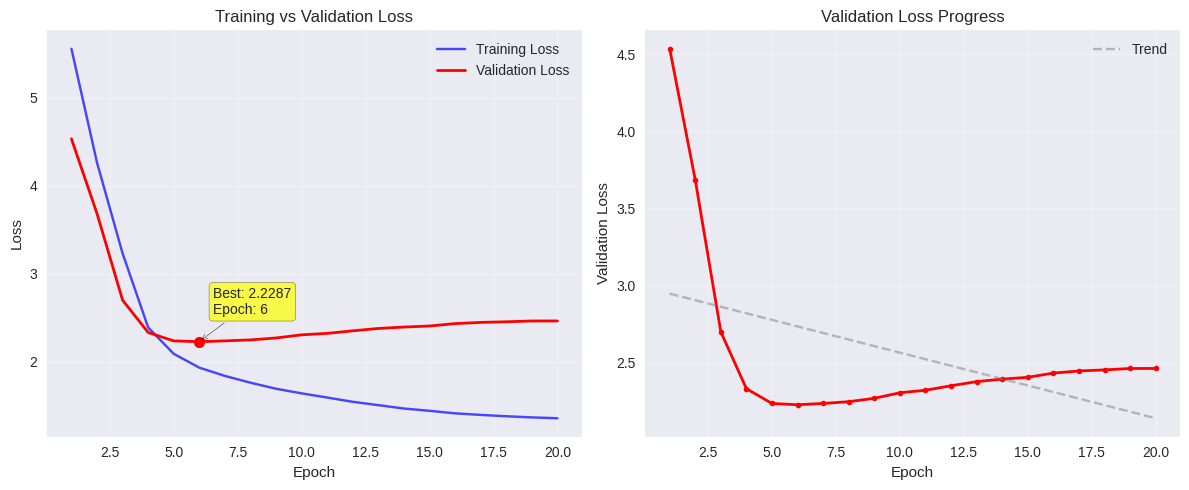

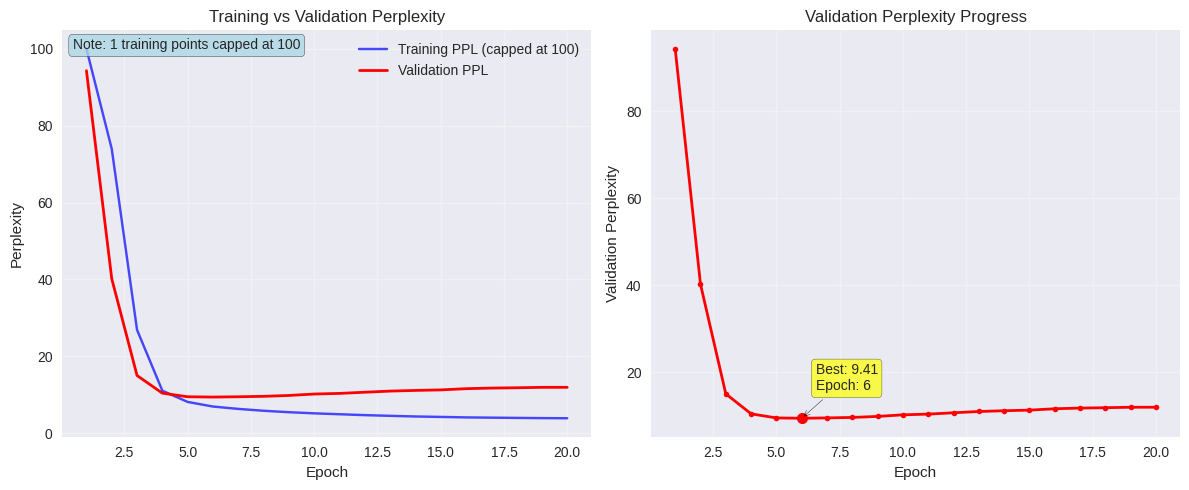

In [ ]:
def visualize_training_results():
  viz = TrainingVisualiser()
  if viz.data:
      viz.create_training_summary()
      viz.plot_loss_curves()
      if 'PPL/valid' in viz.data:
          viz.plot_perplexity_curves()
      return viz
visualize_training_results()

The key parameters are:

Temperature: Controls randomness, higher values increase diversity.

Top-p (nucleus): The cumulative probability cutoff for token selection. Lower values mean sampling from a smaller, more top-weighted nucleus.

Top-k: Sample from the k most likely next tokens at each step. Lower k focuses on higher probability tokens.

In general:

Higher temperature will make outputs more random and diverse.

Lower top-p values reduce diversity and focus on more probable tokens.

Lower top-k also concentrates sampling on the highest probability tokens for each step.